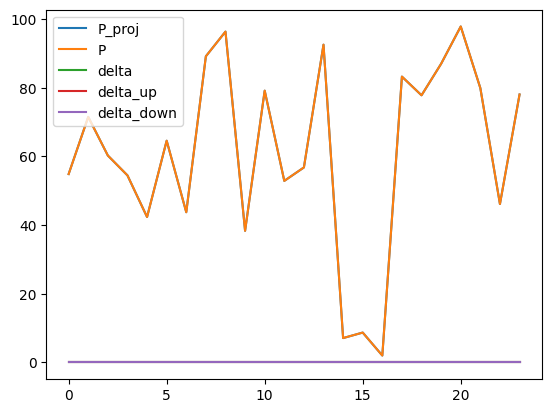

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

def market_bid(lambda_DA, lambda_up, lambda_down, P_proj,  C = 500):

    n = len(P_proj)

    m = gp.Model("market_bid")

    # Create variables
    P_hat = m.addVars(n, lb = 0, ub = C, name="P")
    delta = m.addVars(n, lb = - GRB.INFINITY, ub = GRB.INFINITY, name="delta")
    delta_up = m.addVars(n, lb = 0, ub = GRB.INFINITY, name="delta_up")
    delta_down = m.addVars(n, lb = 0, ub = GRB.INFINITY, name="delta_down")

    # Set objective
    m.setObjective(gp.quicksum(lambda_DA[i] * P_hat[i] + lambda_up[i] * delta_up[i] - lambda_down[i] * delta_down[i] for i in range(n)), GRB.MAXIMIZE)

    # Add constraints
    m.addConstrs(delta[i] == P_proj[i] - P_hat[i]  for i in range(n))
    m.addConstrs(delta[i] == delta_up[i] - delta_down[i]  for i in range(n))

    m.setParam('OutputFlag', 0)
    m.optimize()

    if m.status == GRB.Status.OPTIMAL:
        bid = np.array([P_hat[i].x for i in range(n)])
        delta = np.array([delta[i].x for i in range(n)])
        delta_up = np.array([delta_up[i].x for i in range(n)])
        delta_down = np.array([delta_down[i].x for i in range(n)])
        return bid, delta, delta_up, delta_down
    else:
        print('The model is infeasible')
        return None
    
# Generate mock data
np.random.seed(0)
n = 24
P_proj = np.random.rand(n) * 100
P_proj[P_proj < 0] = 0
lambda_DA = np.random.rand(n) * 10
lambda_up = lambda_DA * 0.9
lambda_down = lambda_DA * 1.1


# Solve the market bid
bid, delta, delta_up, delta_down = market_bid(lambda_DA, lambda_up, lambda_down, P_proj)

# Plot the results
fig, ax = plt.subplots()
ax.plot(P_proj, label='P_proj')
ax.plot(bid, label='P')
ax.plot(delta, label='delta')
ax.plot(delta_up, label='delta_up')
ax.plot(delta_down, label='delta_down')
ax.legend()

plt.show()

In [50]:
def market_bid_org(lambda_DA, lambda_up, lambda_down, P_proj,  C = 500):
    
    t = len(P_proj)
    #### Create model ####
    model = gp.Model()

    #### Decision variables ####
    # Production/bid in DA market
    P_bid = model.addVars(t, lb = 0, ub = C, vtype=GRB.CONTINUOUS, name="P_bid")

    # Binary variables for upward and downward regulation
    u = model.addVars(t, vtype=GRB.BINARY, name="upward_regulation")  # Binary for upward regulation
    d = model.addVars(t, vtype=GRB.BINARY, name="downward_regulation")  # Binary for downward regulation

    #### Set Constraints ####
    # Ensure that in each hour, the wind farm cannot be paid for both upward and downward regulation
    model.addConstrs((u[i] + d[i] <= 1 for i in range(t)), "up_or_down")

    # Ensure that the wind farm is either in upward or downward regulation. 
    model.addConstrs((u[i] + d[i] == 1 for i in range(t)), "regulation")

    # Only allow upward or downward regulation to be non-zero when the respective binary is active.  
    model.addConstrs((lambda_up[i] * (P_bid[i] - P_proj[i]) * u[i] >= 0 for i in range(t)), "upward_nonzero")
    model.addConstrs((lambda_down[i] * (P_proj[i] - P_bid[i]) * d[i] >= 0 for i in range(t)), "downward_nonzero")


    #### Set Objective ####
    model.setObjective(
        gp.quicksum(lambda_DA[i] * P_bid[i] for i in range(t)) + 
        gp.quicksum(lambda_down[i] * (P_proj[i] - P_bid[i]) * d[i] - lambda_up[i] * (P_bid[i] - P_proj[i]) * u[i] for i in range(t)),
        GRB.MAXIMIZE
    )

    #### Optimize ####
    model.setParam('OutputFlag', 0)
    model.optimize()


    #### Print results ####
    """
    print("Optimal production/bid in DA market")
    for i in range(t):
        print(f"t={i}: Bid: {P_bid[i].x}  Projected: {P_proj[i]} Day-ahead price: {lambda_DA[i]} Upward price: {lambda_up[i]} Downward price: {lambda_down[i]}  Binary up: {u[i].x}  Binary down: {d[i].x}")
    
    print("Objective value")
    print(model.objVal)
    """
    bid = model.getAttr("X", P_bid)
    bid = np.array([bid[i] for i in range(t)])
    return bid

In [53]:
bid, delta, delta_up, delta_down = market_bid(lambda_DA, lambda_up, lambda_down, P_proj)
bid_alt = market_bid_org(lambda_DA, lambda_up, lambda_down, P_proj)

# Check if the two implementations give the same result
print(bid)

print(bid_alt)


[54.88135039 71.51893664 60.27633761 54.4883183  42.36547993 64.58941131
 43.75872113 89.17730008 96.36627605 38.34415188 79.17250381 52.88949198
 56.80445611 92.55966383  7.10360582  8.71292997  2.02183974 83.26198455
 77.81567509 87.00121482 97.86183422 79.91585642 46.14793623 78.05291763]
[500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.]
